# Kaggle histopathology introduction
This notebook is an introduction to the data challenge of out of distribution classification of histopathology patches. It also serves as a baseline for the code and the model.

If you have any questions, feel free to contact me at [leo.fillioux@centralesupelec.fr](mailto:leo.fillioux@centralesupelec.fr).

In [1]:
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
import h5py
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.models import vit_b_16
import torch.nn.functional as F
from tqdm import tqdm
import scipy


In [2]:
TRAIN_IMAGES_PATH = 'train.h5'
VAL_IMAGES_PATH = 'val.h5'
TEST_IMAGES_PATH = 'test.h5'
SEED = 0

In [3]:
torch.random.manual_seed(SEED)
random.seed(SEED)

## 1. Introduction to the data
The dataset consists of patches of whole slide images which should be classified into either containing tumor or not. The training images come from 3 different centers (i.e. hospitals), while the validation set comes from another center and the test set from yet another center. The visual aspect of the patches are quite different due to the slightly different staining procedures, conditions, and equipment from each hospital. The objective of the task is to build a classifier that is impacted by this distribution shift as little as possible.

The data is stored in `.h5` files, which can be seen as a folder hierarchy, which are can be seen as the following.
```
├── idx           # index of the image
│   └── img       # image in a tensor format
│   └── label     # binary label of the image
│   └── metadata  # some metadata on the images
```
The metadata is included for completeness but is not necessarily useful. The first element in the metadata corresponds to the center.

The following is a visualization of how different the images look from the different centers.

In [4]:
train_images = {0: {0: None, 1: None},
                3: {0: None, 1: None},
                4: {0: None, 1: None}}
val_images = {1: {0: None, 1: None}}

In [5]:
for img_data, data_path in zip([train_images, val_images], [TRAIN_IMAGES_PATH, VAL_IMAGES_PATH]):
    with h5py.File(data_path, 'r') as hdf:
        for img_idx in list(hdf.keys()):
            label = int(np.array(hdf.get(img_idx).get('label')))
            center = int(np.array(hdf.get(img_idx).get('metadata'))[0])
            if img_data[center][label] is None:
                img_data[center][label] = np.array(hdf.get(img_idx).get('img'))
            if all(all(value is not None for value in inner_dict.values()) for inner_dict in img_data.values()):
                break
all_data = {**train_images, **val_images}

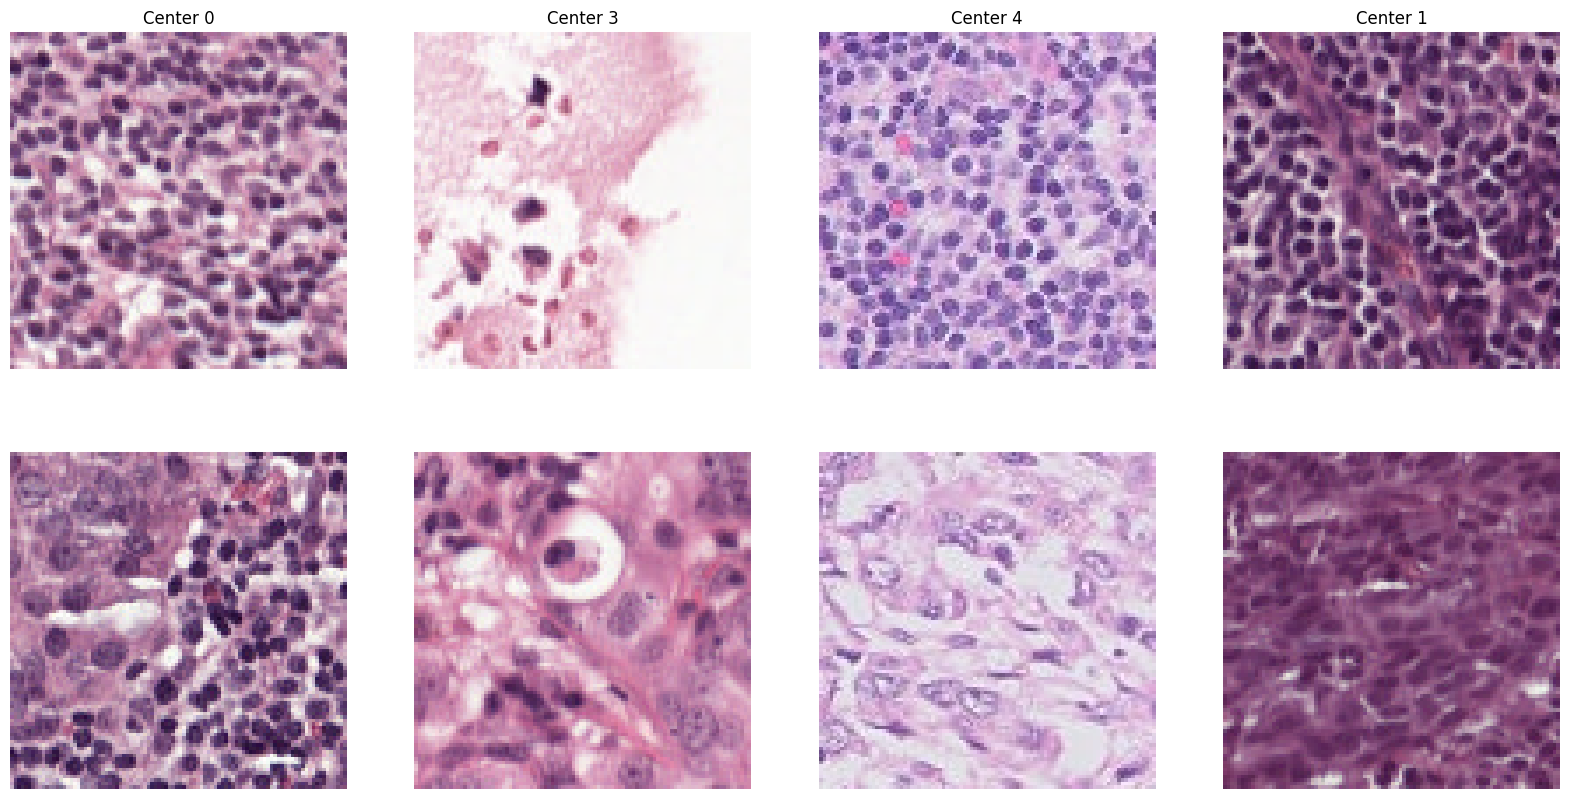

In [6]:
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
center_ids = {center: idx for idx, center in enumerate(all_data.keys())}
for center in all_data:
    for label in all_data[center]:
        axs[label, center_ids[center]].imshow(np.moveaxis(all_data[center][label], 0, -1).astype(np.float32))
        axs[label, center_ids[center]].axis('off')
        if label == 0:
            axs[label, center_ids[center]].set_title(f'Center {center}')
plt.show()

## 2. Data augmentation

In [ ]:
# mainly taken from the segmentation lab

class AxialFlip(object):
    def __call__(self, img):
        choice_x = np.random.randint(0, 2)
        choice_y = np.random.randint(0, 2)

        new_img = self.axialflip(img, choice_x, choice_y)
        return new_img

    def axialflip(self, array, choice_x, choice_y):
        if choice_x == 1:  
            array = array[:, ::-1, :]
        if choice_y == 1:  
            array = array[:, :, ::-1]
        return np.ascontiguousarray(array)

class RandomRotation90(object):
    def __init__(self, num_rot=(1, 2, 3, 4)):
        self.num_rot = num_rot
        self.axes = (1, 2)

    def __call__(self, img):
        num_rot = np.random.choice(self.num_rot)
        def f(img):
            if img is None:
                return None
            return np.ascontiguousarray(np.rot90(img, num_rot, self.axes))
        
        new_img = f(img)
        return new_img
    

def RandomTranslation(max_translation=30, transform_matrix=None, debug=False):
    translation = np.random.randint(-max_translation, max_translation, 2)
    if debug:
        return getTranslationMatrix(translation, transform_matrix), (translation)
    else:
        return getTranslationMatrix(translation, transform_matrix)

def RandomRotation(theta_max=20, transform_matrix=None, debug=False):
    theta = np.random.uniform(-theta_max, theta_max)
    if debug:
        return getRotationMatrix(theta, transform_matrix), theta
    else:
        return getRotationMatrix(theta, transform_matrix)

def RandomZoom(zoom_max=0.2, transform_matrix=None, debug=False):
    zoom = np.random.uniform(1 - zoom_max, 1 + zoom_max)
    if debug:
          return getZoomMatrix(zoom, transform_matrix), zoom
    else:
        return getZoomMatrix(zoom, transform_matrix)

def getTranslationMatrix(translation, transform_matrix=None):
    shift_matrix = np.array([[1, 0, translation[0]],
                            [0, 1, translation[1]],
                            [0, 0, 1]])

    if transform_matrix is None:
        transform_matrix = shift_matrix
    else:
        transform_matrix = np.dot(transform_matrix, shift_matrix)
    return transform_matrix

def getZoomMatrix(zoom, transform_matrix=None):
    zoom_matrix = np.array([[zoom, 0, 0],
                            [0, zoom, 0],
                            [0, 0, 1]])
    if transform_matrix is None:
        transform_matrix = zoom_matrix
    else:
        transform_matrix = np.dot(transform_matrix, zoom_matrix)
    return transform_matrix

def getRotationMatrix(theta, transform_matrix=None):
    theta = np.deg2rad(theta)
    rotation_matrix = np.array([[np.cos(theta), -np.sin(theta), 0],
                                [np.sin(theta), np.cos(theta), 0],
                                [0, 0, 1]])
    if transform_matrix is None:
        transform_matrix = rotation_matrix
    else:
        transform_matrix = np.dot(transform_matrix, rotation_matrix)
    return transform_matrix

def transform_matrix_offset_center(matrix, x, y):
    o_x = float(x) / 2 + 0.5
    o_y = float(y) / 2 + 0.5
    offset_matrix = np.array([[1, 0, o_x],
                              [0, 1, o_y],
                              [0, 0, 1]])
    reset_matrix = np.array([[1, 0, -o_x],
                             [0, 1, -o_y],
                             [0, 0, 1]])
    transform_matrix = np.dot(np.dot(offset_matrix, matrix), reset_matrix)
    return transform_matrix

def apply_affine_transform(x, seg=None, transform_matrix=None, crop_shape=None,
                          fill_mode='nearest', cval=0., order=3):
    if transform_matrix is not None:
        if x.dtype == np.float16:
            x = x.astype(np.float32)
            if seg is not None:
                seg = seg.astype(np.float32)
        
        channels, h, w = x.shape
        transform_matrix = transform_matrix_offset_center(transform_matrix, h, w)
        res = [scipy.ndimage.affine_transform(x[channel, ...], transform_matrix,
                                            order=order, mode=fill_mode, cval=cval) for channel in range(channels)]
        x = np.stack(res, axis=0)
        if seg is not None:
            labels = seg.shape[0]
            res = [scipy.ndimage.affine_transform(seg[label, ...], transform_matrix,
                                                order=order, mode=fill_mode, cval=cval) for label in range(labels)]
            seg = np.stack(res, axis=0)
            seg[seg > 0.5] = 1
            seg[seg < 0.5] = 0
            return x, seg
    return x

class AffineTransform(object):
    def __init__(self, theta=0, max_translation=0, max_zoom=0):
        self.theta = theta
        self.max_translation = max_translation
        self.max_zoom = max_zoom
    
    def __call__(self, img):
        
        original_dtype = img.dtype
        if original_dtype == np.float16:
            img = img.astype(np.float32)
            
        transform_matrix = np.eye(3)
        if self.theta > 0:
            transform_matrix = RandomRotation(self.theta)
        if self.max_translation > 0:
            transform_matrix = RandomTranslation(self.max_translation, transform_matrix)
        if self.max_zoom > 0:
            transform_matrix = RandomZoom(self.max_zoom, transform_matrix)
        
        new_img = apply_affine_transform(img, None, transform_matrix)

        return (new_img)


## 3. Dataset

In [ ]:
class AugmentedDataset(Dataset):
    def __init__(self, dataset_path, mode='train', apply_augmentation=True):
        super(AugmentedDataset, self).__init__()
        self.dataset_path = dataset_path
        self.mode = mode
        self.apply_augmentation = apply_augmentation
        
        with h5py.File(self.dataset_path, 'r') as hdf:        
            self.image_ids = list(hdf.keys())
        
        # Those augmentations are performed randomly
        self.augmentations = [
            AxialFlip(),
            RandomRotation90(),
            AffineTransform(theta=10, max_translation=10, max_zoom=0.2),

        ]
        
        # Those augmentations are always used
        self.mandatory_transforms = [
            transforms.ToTensor(),
            transforms.Resize((224, 224)),
            transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                std=[0.229, 0.224, 0.225]),
        ]


    def __len__(self):
        return len(self.image_ids)
    
    def apply_transforms(self, img, label=None):
        if isinstance(img, np.ndarray) and img.dtype == np.float16:
            img = img.astype(np.float32)
        
        # Apply data augmentation if in training mode
        if self.mode == 'train' and self.apply_augmentation:
            for transform in self.augmentations:
                 # Apply 2 times oout of 3
                if np.random.random() > 0.66:
                    try:
                        img = transform(img)
                    except Exception as e:
                        print(f"Error applying transform {transform.__class__.__name__}: {e}")
                        continue
        
        if isinstance(img, np.ndarray) and img.shape[0] == 3:
            img = np.transpose(img, (1, 2, 0))
            
        for transform in self.mandatory_transforms:
            img = transform(img)
        
        # Convert to tensor and normalize
        if isinstance(img, np.ndarray):
            img = torch.from_numpy(img).float()
        img = torch.nan_to_num(img)        
        if img.shape[0] == 1:
            img = img.repeat(3, 1, 1)

        return img, label

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        with h5py.File(self.dataset_path, 'r') as hdf:
            img = np.array(hdf.get(img_id).get('img'))
            label = int(np.array(hdf.get(img_id).get('label')))

        img_copy = img.copy()
        
        try:
            aug_img, _ = self.apply_transforms(img_copy, None)
        except Exception as e:
            print(f"Error during transforms for image {img_id}, using original image. Error: {e}")
            aug_img = img_copy
            
        return aug_img, label

In [ ]:
def visualize_augmentations(dataset, num_samples=4):
    fig, axes = plt.subplots(2, num_samples, figsize=(15, 6))
    indices = np.random.choice(len(dataset), num_samples, replace=False)
    
    for i, idx in enumerate(indices):
        with h5py.File(dataset.dataset_path, 'r') as hdf:
            img_id = dataset.image_ids[idx]
            original_img = np.array(hdf.get(img_id).get('img'))
            if original_img.dtype == np.float16:
                original_img = original_img.astype(np.float32)
            label = np.array(hdf.get(img_id).get('label')) if dataset.mode == 'train' else None
            
        # original image
        axes[0, i].imshow(np.transpose(original_img, (1, 2, 0)))
        axes[0, i].set_title(f"Original (Label: {label})")
        axes[0, i].axis('off')
        
                   
        img_copy = original_img.copy()
        aug_img, _ = dataset.apply_transforms(img_copy, None)
        aug_img = aug_img.cpu().numpy()
        
        # Unnormalize for viz
        aug_img = aug_img * np.array([0.229, 0.224, 0.225])[:, None, None] + np.array([0.485, 0.456, 0.406])[:, None, None]

        aug_img = np.clip(aug_img, 0, 1)
        
        # augmented image
        axes[1, i].imshow(np.transpose(aug_img, (1, 2, 0)))
        axes[1, i].set_title("Augmented")
        axes[1, i].axis('off')
    
    plt.tight_layout()
    plt.show()

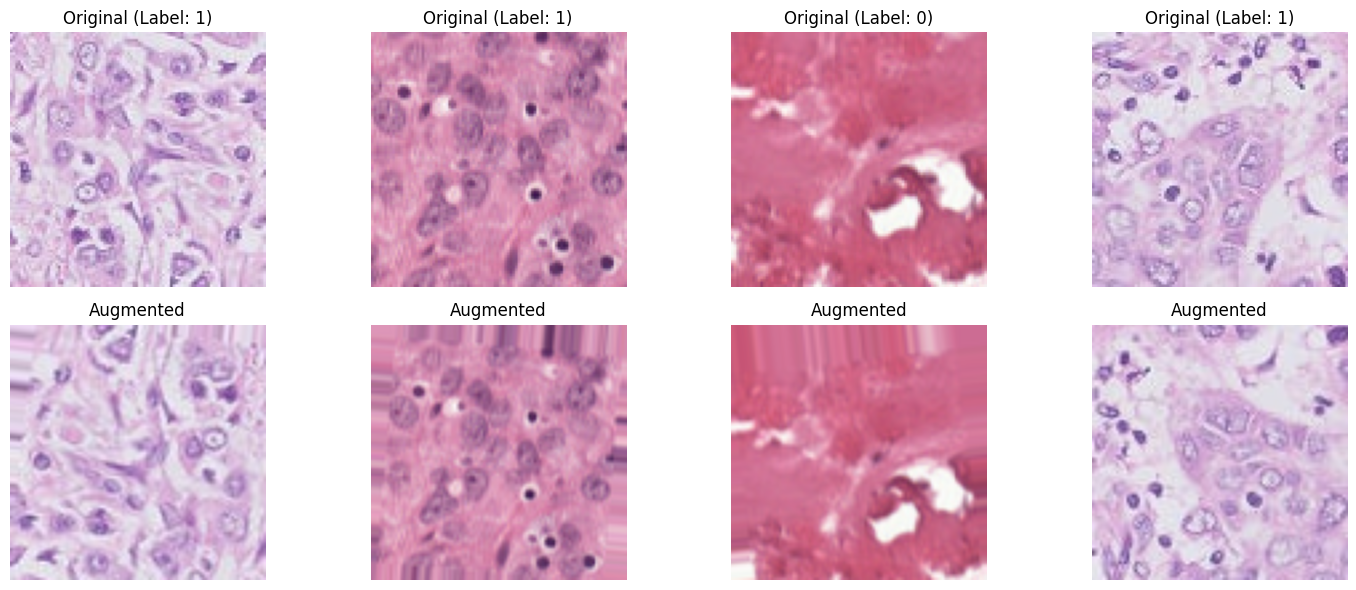

In [ ]:
train_dataset = AugmentedDataset(TRAIN_IMAGES_PATH, mode='train')
val_dataset = AugmentedDataset(VAL_IMAGES_PATH, mode='train', apply_augmentation=False)

visualize_augmentations(train_dataset, num_samples=4)


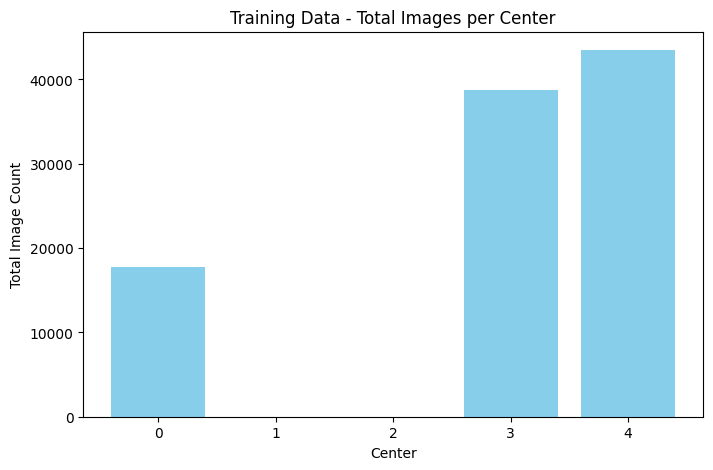

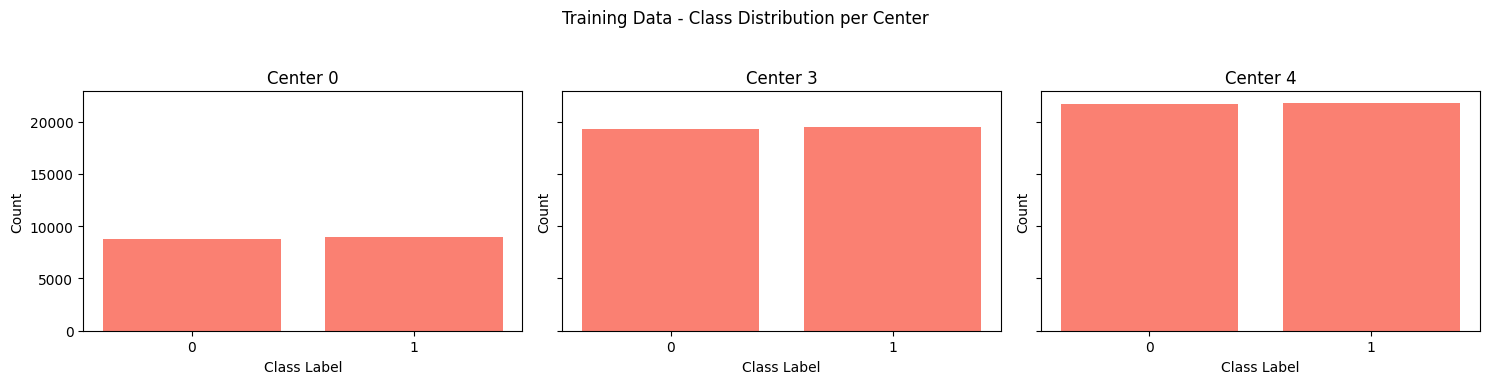

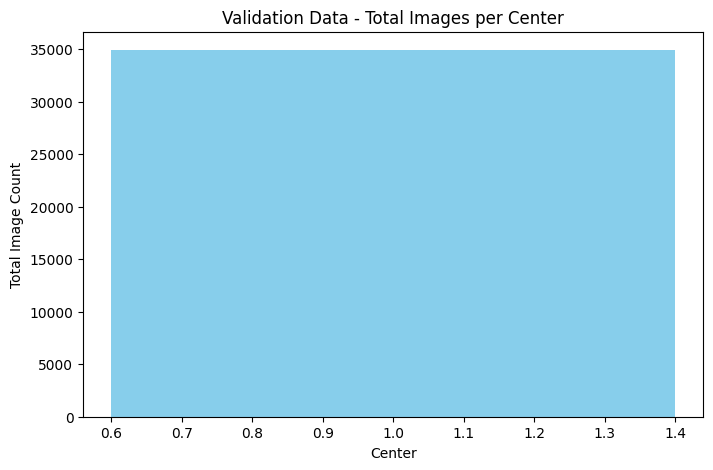

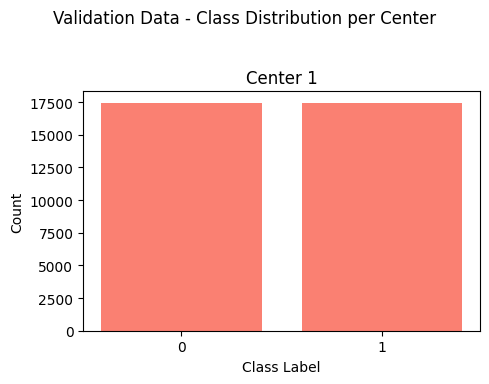

In [ ]:
from collections import defaultdict

# Function to compute counts per center and per class from a given dataset.
def compute_stats(dataset_path):
    center_counts = defaultdict(lambda: defaultdict(int))
    with h5py.File(dataset_path, 'r') as hdf:
        for img_id in hdf.keys():
            label = int(np.array(hdf.get(img_id).get('label')))
            center = int(np.array(hdf.get(img_id).get('metadata'))[0])
            center_counts[center][label] += 1
    return center_counts

train_stats = compute_stats(TRAIN_IMAGES_PATH)
val_stats = compute_stats(VAL_IMAGES_PATH)

def plot_center_stats(center_counts, title_prefix='Dataset'):
    centers = sorted(center_counts.keys())
    
    # Overall counts per center.
    overall = [sum(center_counts[c].values()) for c in centers]
    plt.figure(figsize=(8, 5))
    plt.bar(centers, overall, color='skyblue')
    plt.xlabel("Center")
    plt.ylabel("Total Image Count")
    plt.title(f"{title_prefix} - Total Images per Center")
    plt.show()

    labels = [0, 1]
    
    fig, axes = plt.subplots(1, len(centers), figsize=(5 * len(centers), 4), sharey=True)
    if len(centers) == 1:
        axes = [axes]
    
    for ax, center in zip(axes, centers):
        counts = [center_counts[center].get(lbl, 0) for lbl in labels]
        ax.bar(labels, counts, color='salmon')
        ax.set_title(f"Center {center}")
        ax.set_xlabel("Class Label")
        ax.set_ylabel("Count")
        ax.set_xticks(labels)
    plt.suptitle(f"{title_prefix} - Class Distribution per Center")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

plot_center_stats(train_stats, title_prefix='Training Data')
plot_center_stats(val_stats, title_prefix='Validation Data')


## 3. Training model
The baseline model consists of extracting DINOv2 embeddings and linear probing.

In [ ]:
# DINO_v2 feature extractor

class DINOv2FeatureExtractor:
    def __init__(self, device='cuda' if torch.cuda.is_available() else 'cpu'):
        self.device = device

        self.model = vit_b_16(pretrained=True)
        self.model.heads = nn.Identity()
        self.model.to(device)
        self.model.eval()
    
    def extract_features(self, dataloader):
        features = []
        labels = []
        
        with torch.no_grad():
            for imgs, lbls in tqdm(dataloader):
                imgs = imgs.to(self.device)
                embeddings = self.model(imgs)
                features.append(embeddings.cpu())
                if lbls is not None:
                    labels.append(lbls)
        
        features = torch.cat(features, dim=0)
        if labels and labels[0] is not None:
            labels = torch.cat(labels, dim=0)
            return features, labels
        return features, None

class BinaryClassifier(nn.Module):
    def __init__(self, input_dim=768):
        super(BinaryClassifier, self).__init__()
        self.classifier = nn.Sequential(
            nn.Linear(input_dim, 256),
            nn.Dropout(0.3),
            nn.Sigmoid()
        )
    
    def forward(self, x):
        return self.classifier(x).squeeze()
    
# We use an end-to-end model instead of precomputing features once to get full 
# benefits of data augmentation
class EndToEndModel(nn.Module):
    def __init__(self, feature_extractor, classifier):
        super(EndToEndModel, self).__init__()
        self.feature_extractor = feature_extractor
        self.classifier = classifier

    def forward(self, x):
        features = self.feature_extractor.model(x)
        outputs = self.classifier(features)
        return outputs


In [ ]:
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"device: {device}")
feature_extractor = DINOv2FeatureExtractor()
classifier = BinaryClassifier(input_dim=768)
model = EndToEndModel(feature_extractor, classifier).to(device)

for param in model.feature_extractor.model.parameters(): # we don't train dinov2
    param.requires_grad = False

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCELoss()

num_epochs = 20
train_losses = []
val_losses = []

# Early stopping
patience = 3
best_val_loss = float('inf')
epochs_without_improvement = 0

for epoch in range(num_epochs):
    model.train()
    total_loss = 0.0

    for imgs, lbls in tqdm(train_loader):
        imgs, lbls = imgs.to(device), lbls.to(device)
        optimizer.zero_grad()
        
        outputs = model(imgs)
        loss = criterion(outputs, lbls.float())
        
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    
    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    
    if val_loader is not None:
        model.eval()
        total_val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for imgs, lbls in val_loader:
                imgs, lbls = imgs.to(device), lbls.to(device)
                outputs = model(imgs)
                loss = criterion(outputs, lbls.float())
                total_val_loss += loss.item()
                preds = (outputs >= 0.5).float()
                correct += (preds == lbls).sum().item()
                total += lbls.size(0)
        avg_val_loss = total_val_loss / len(val_loader)
        val_losses.append(avg_val_loss)
        val_accuracy = correct / total
        
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, '
              f'Val Loss: {avg_val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
        
        # Early stopping
        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            epochs_without_improvement = 0
            torch.save(model.state_dict(), 'best_model.pth')
            print("Meilleur modèle sauvegardé.")
        else:
            epochs_without_improvement += 1
            print(f"Pas d'amélioration pendant {epochs_without_improvement} époques.")
        
        # Stop le training si le nombre d'époques sans amélioration atteint la tolérance
        if epochs_without_improvement >= patience:
            print("Early stopping.")
            break
    else:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}')

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss')
if val_losses:
    plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training et Validation Loss')
plt.legend()
plt.show()

torch.save(model.state_dict(), 'binary_classifier_end2end.pth')


device: cuda


/raid/home/automatants/tabbara_pau/dlip/dlip_venv/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/raid/home/automatants/tabbara_pau/dlip/dlip_venv/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/782 [00:00<?, ?it/s]/raid/home/automatants/tabbara_pau/dlip/dlip_venv/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change